# Lead Scoring Case Study:

### Problem Statement:
An education company named X Education sells online courses to industry professionals. The company markets its courses on several websites and search engines like Google. Once someone provides their email or phone number, they are considered to be a Lead. A lead is obtained through their website or referrals. Through the marketing teams, these leads are converted into Sales. Currently, the conversion rate is only around 30%

### Objective:
To build a model wherein a lead score is assigned to each of the leads such that the customers with a higher chance of conversion (Hot Lead) is assigned a higher lead score, as compared to those that are less likely to be converted to a customer (Cold Lead).

In [139]:
# Import all relevant libraries:

import pandas as pd, numpy as np
import seaborn as sns, matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [140]:
pd.options.display.max_columns = 200

In [141]:
# Read and understand the data:
df = pd.read_csv("Leads.csv")
df.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [143]:
df.describe()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Asymmetrique Activity Score,Asymmetrique Profile Score
count,9240.000000,9240.000000,9103.000000,9240.000000,9103.000000,5022.000000,5022.000000
mean,617188.435606,0.385390,3.445238,487.698268,2.362820,14.306252,16.344883
std,23405.995698,0.486714,4.854853,548.021466,2.161418,1.386694,1.811395
min,579533.000000,0.000000,0.000000,0.000000,0.000000,7.000000,11.000000
25%,596484.500000,0.000000,1.000000,12.000000,1.000000,14.000000,15.000000
50%,615479.000000,0.000000,3.000000,248.000000,2.000000,14.000000,16.000000
75%,637387.250000,1.000000,5.000000,936.000000,3.000000,15.000000,18.000000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000,18.000000,20.000000


Note: Have identified that numeric columns - TotalVisits, Total Time Spent on Website, Page Views Per Visit - potentially have outliers. These have to be further looked into later on.

### Cleaning the data:

In [144]:
# Change "Select" to is null, since that indicates that no option was selected from the drop down.
df.replace("Select", np.nan, inplace=True)

# Drop columns that have only 1 response, since it won't provide any insightful information to the analysis:
df.drop(["Receive More Updates About Our Courses", "Update me on Supply Chain Content", "Get updates on DM Content",
   "I agree to pay the amount through cheque"],inplace=True, axis=1)

# Drop columns where majoring of the data is classified in 1 category, and other categories have insignificant 
# amount of data (data imbalance), since it won't provide any insightful information to the analysis:
df.drop(["Country","Search", "Magazine", "Newspaper Article", "X Education Forums", "Newspaper", "Digital Advertisement", "Through Recommendations", "What matters most to you in choosing a course"], inplace=True, axis=1)

# Changing the column name to "Receive emails?" and "Receive calls?" to avoid confusion 
# and change Yes and No to binary figures.

# Note: Here Yes would be 0 and No would be 1, since the column interpretation has changed.

df.rename(columns = {"Do Not Email":"Receive Emails?", "Do Not Call":"Receive Calls?"}, inplace=True)
df["Receive Emails?"].replace(("Yes", "No"), (0,1), inplace=True)
df["Receive Calls?"].replace(("Yes", "No"), (0,1), inplace=True)


In [145]:
print(df["Lead Number"].unique().shape)
# Confirmed that there are no repetitions in the lead numbers.

# Drop Prospect ID, since Lead number is easier to read:
df.drop("Prospect ID", inplace=True, axis=1)

(9240,)


In [146]:
(df.isnull().sum()/ len(df.isnull())) * 100

Lead Number                                0.000000
Lead Origin                                0.000000
Lead Source                                0.389610
Receive Emails?                            0.000000
Receive Calls?                             0.000000
Converted                                  0.000000
TotalVisits                                1.482684
Total Time Spent on Website                0.000000
Page Views Per Visit                       1.482684
Last Activity                              1.114719
Specialization                            36.580087
How did you hear about X Education        78.463203
What is your current occupation           29.112554
Tags                                      36.287879
Lead Quality                              51.590909
Lead Profile                              74.188312
City                                      39.707792
Asymmetrique Activity Index               45.649351
Asymmetrique Profile Index                45.649351
Asymmetrique

In [147]:
# Drop columns where majority of the data is missing, and where columns seem unimportant:
df.drop(["Asymmetrique Activity Index", "Asymmetrique Profile Index", 
         "Asymmetrique Activity Score", "Asymmetrique Profile Score", 
         "Lead Profile", "How did you hear about X Education"], axis=1, inplace=True)

In [148]:
# Replace Null with Unknown:
df["Lead Quality"].fillna("Unknown", inplace=True)
df["Tags"].fillna("Unknown", inplace=True)
df["City"].fillna("Unknown", inplace=True)
df["Specialization"].fillna("Unknown", inplace=True)

# Replace Null with Mode (where the category with highest data is much higher than the rest):
df["What is your current occupation"].fillna(df["What is your current occupation"].mode()[0], inplace=True)


In [149]:
# Drop null rows, since it's a very small percentage, 
# and lot of the other columns are "Unknown" as well:

df = df[-df["TotalVisits"].isnull()]
df = df[-df["Lead Source"].isnull()]

In [150]:
# Check if all null values have been dealt with:
df.isnull().sum().sum()

0

### EDA

In [151]:
# Check the conversion rate:
(df.Converted.sum()/len(df.Converted))*100

37.85541106458012

This indicates that around 38% of the leads are actually converted into customers.

In [152]:
df.columns

Index(['Lead Number', 'Lead Origin', 'Lead Source', 'Receive Emails?',
       'Receive Calls?', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity',
       'Specialization', 'What is your current occupation', 'Tags',
       'Lead Quality', 'City', 'A free copy of Mastering The Interview',
       'Last Notable Activity'],
      dtype='object')

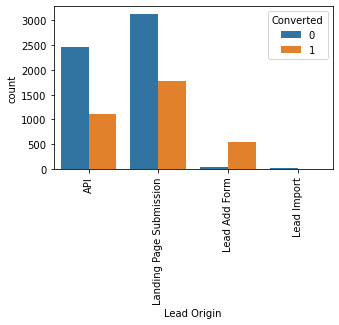

In [153]:
plt.figure(figsize=[5,3])
sns.countplot(data=df, x="Lead Origin", hue="Converted")
plt.xticks(rotation = 90)
plt.show()


Those leads belonging to those categories with a higher conversion rate must be given more emphasis, since that indicates a higher chance of being converted into a customer.

With regards to Lead Origins, conversion rate through Lead Add Form are around 90%. Therefore, could be an important variable.


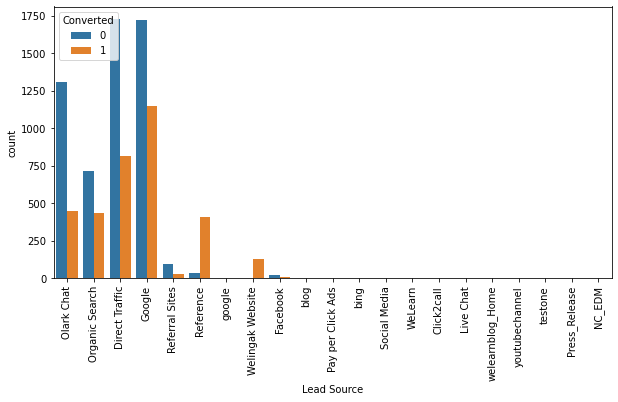

In [154]:
plt.figure(figsize=[10,5])
sns.countplot(data=df, x="Lead Source", hue="Converted")
plt.xticks(rotation = 90)
plt.show()

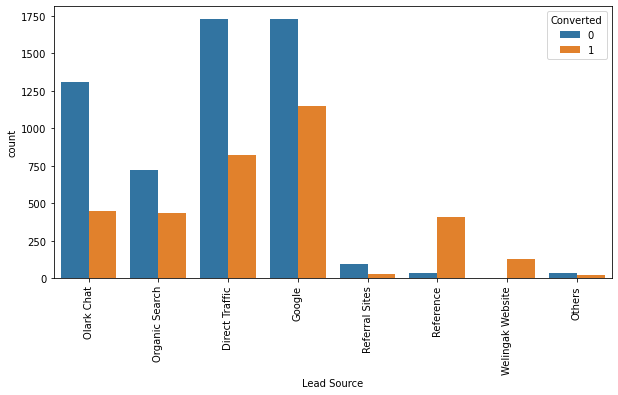

In [155]:
df["Lead Source"].replace("google", "Google", inplace=True)
df["Lead Source"].replace(["bing", "Click2call", "Press_Release", "Live Chat", "Social Media","welearnblog_Home",
                          "blog", "testone","Pay per Click Ads", "youtubechannel", "NC_EDM", "WeLearn", "Facebook"], "Others", inplace=True)
plt.figure(figsize=[10,5])
sns.countplot(data=df, x="Lead Source", hue="Converted")
plt.xticks(rotation = 90)
plt.show()

Conversion rates through References and Welingak Website as Lead Sources, are high. Olark Chat, Organic Research, Direct Traffic and Google are potential sources that can be improved on. We have merged the other data to Others since they did not consistute a significant portion of the data, and for ease of analysis.


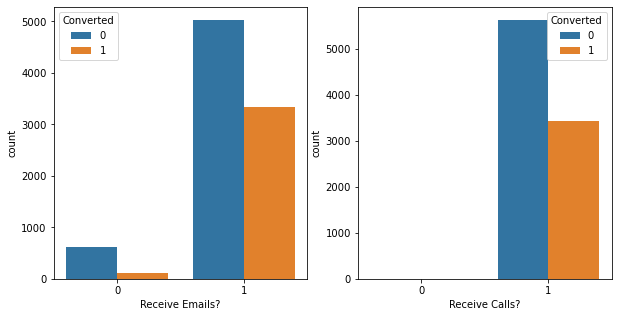

In [156]:
plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
sns.countplot(data=df, x="Receive Emails?", hue="Converted")
plt.subplot(1,2,2)
sns.countplot(data=df, x="Receive Calls?", hue="Converted")
plt.show()

Those leads that say Yes to receiving emails and calls have higher chances of being converted to customers.


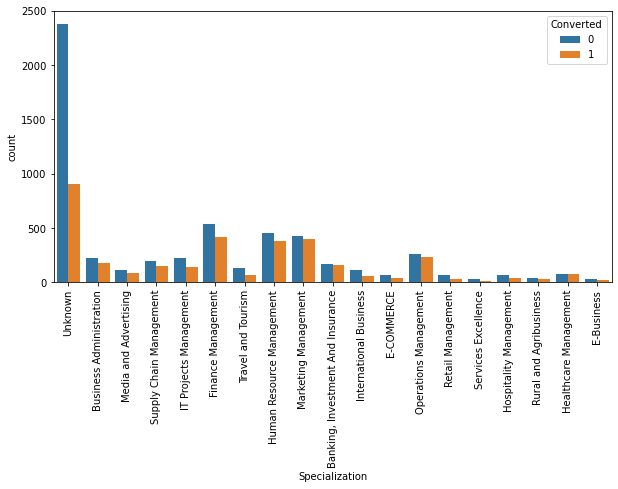

In [157]:
plt.figure(figsize=[10,5])
sns.countplot(data=df, x="Specialization", hue="Converted")
plt.xticks(rotation = 90)
plt.show()

Leads with specializations in the following fields, show a trend of slightly higher conversion rate, that the rest-  Operations Management, Marketing Management, etc.


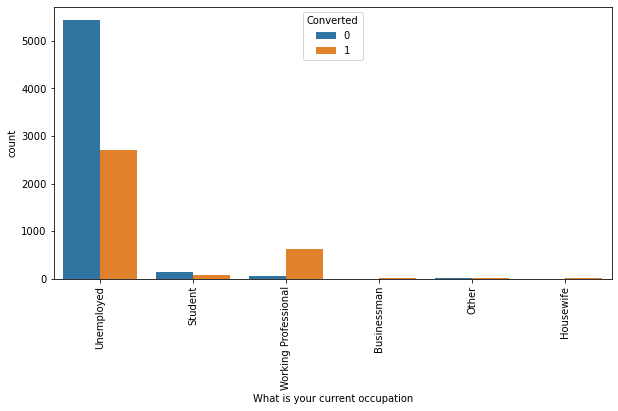

In [158]:
plt.figure(figsize=[10,5])
sns.countplot(data=df, x="What is your current occupation", hue="Converted")
plt.xticks(rotation = 90)
plt.show()

Leads who are professionals have a higher chance of enrolling in courses, as compared to unemployed individuals and students. 


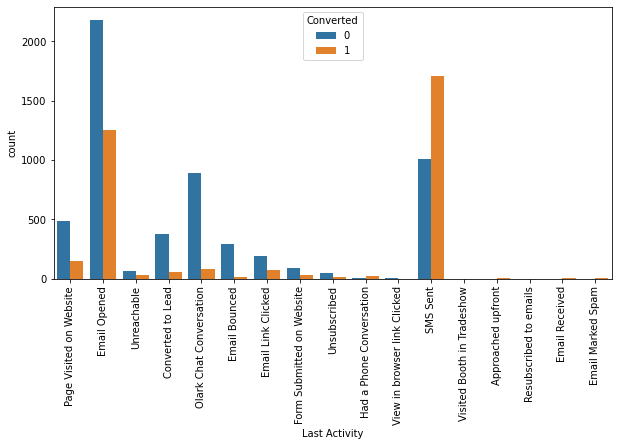

In [159]:
plt.figure(figsize=[10,5])
sns.countplot(data=df, x="Last Activity", hue="Converted")
plt.xticks(rotation = 90)
plt.show()

In [160]:
df["Last Activity"].replace(["Had a Phone Conversation","View in browser link Clicked", "Approached upfront", "Email Received",
                            "Email Marked Spam", "Visited Booth in Tradeshow", "Resubscribed to emails"],
                           "Others", inplace=True)

In [161]:
df["Last Notable Activity"].replace(["Email Marked Spam","Email Received","View in browser link Clicked",
                                    "Form Submitted on Website","Resubscribed to emails", "Approached upfront",
                                    "Had a Phone Conversation","Unreachable","Unsubscribed","Email Bounced"],"Others",inplace=True)


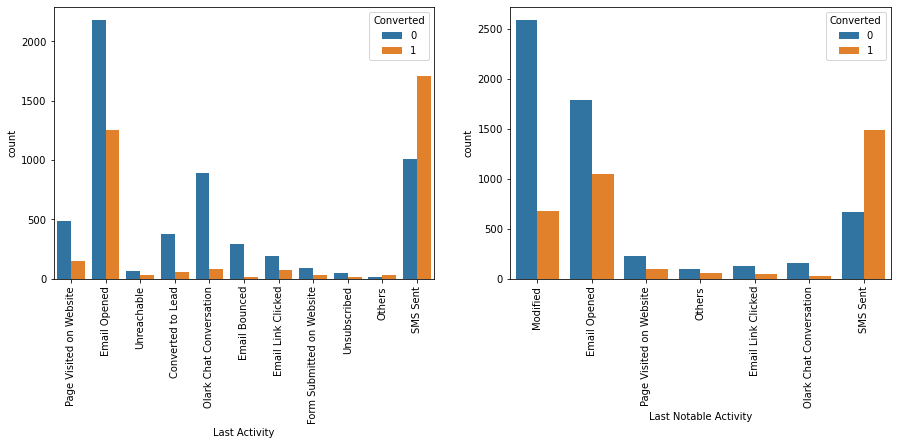

In [162]:
plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
sns.countplot(data=df, x="Last Activity", hue="Converted")
plt.xticks(rotation = 90)

plt.subplot(1,2,2)
sns.countplot(data=df, x="Last Notable Activity", hue="Converted")
plt.xticks(rotation = 90)
plt.show()


SMS Sent as the Last activity and Last Notable Activity, has the highest conversion rate.

Activities with low counts, have been combined and labelled "Others" for ease of further analysis.

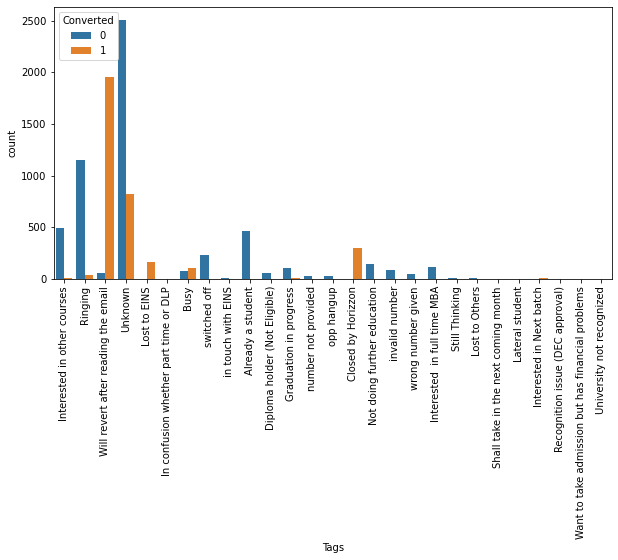

In [163]:
plt.figure(figsize=[10,5])
sns.countplot(data=df, x="Tags", hue="Converted")
plt.xticks(rotation = 90)
plt.show()

In [164]:
df["Tags"].replace(["Still Thinking", "Want to take admission but has financial problems"       
"Interested in Next batch","In confusion whether part time or DLP","Lateral student","University not recognized",
                    "Shall take in the next coming month","Recognition issue (DEC approval)","in touch with EINS",
                   "Interested in Next batch", "Want to take admission but has financial problems",
                   "Lost to Others","opp hangup", "number not provided"],"Others", inplace=True)                      

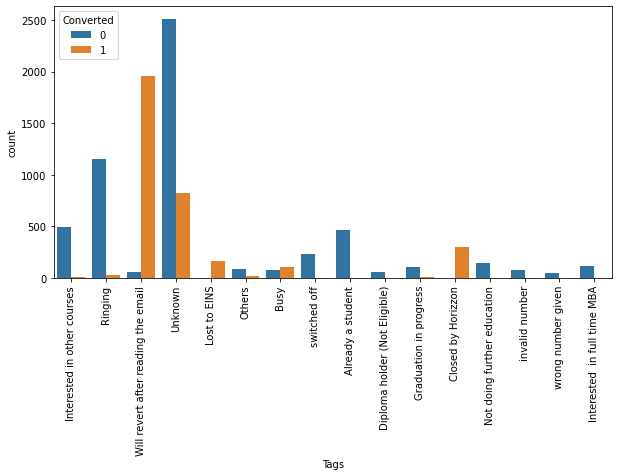

In [165]:
plt.figure(figsize=[10,5])
sns.countplot(data=df, x="Tags", hue="Converted")
plt.xticks(rotation = 90)
plt.show()

With regards to Tags, those that have been tagged as "Revert after reading emails", has the highest covnersion rate. Although, those tagged as "Closed by Horizzon" and "Lost to EINS" have high conversion rates too, which is contradicting to the tag names. These should be further investigated.

Tags with really low values, have been combined to form a new category "Others", for ease of analysis.


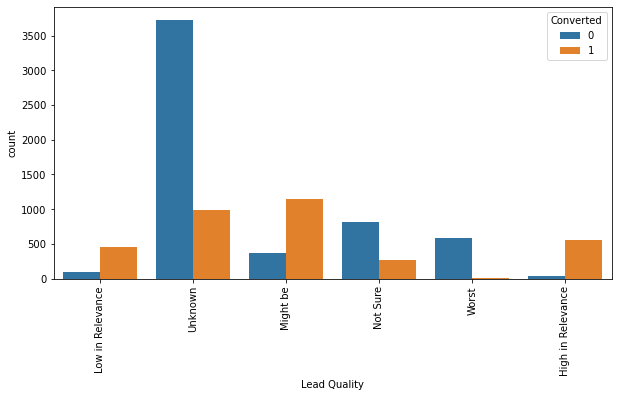

In [166]:
plt.figure(figsize=[10,5])
sns.countplot(data=df, x="Lead Quality", hue="Converted")
plt.xticks(rotation = 90)
plt.show()

Lead quality classifications as well may have to be further investigated, as those categorized as "High relevance", "Low Relevance" and "Maybe", have a high conversion rate, which is again contradicting to the labels itself.

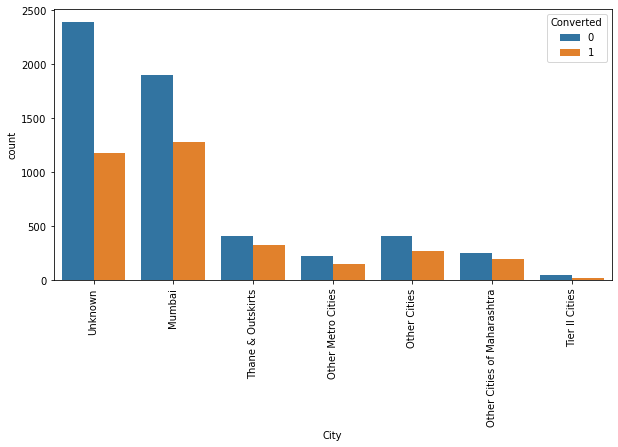

In [167]:
plt.figure(figsize=[10,5])
sns.countplot(data=df, x="City", hue="Converted")
plt.xticks(rotation = 90)
plt.show()

No visible patterns can be seen when it comes to the city the leads are from.

### Check for outliers:

In [168]:
df.describe()

,Lead Number,Receive Emails?,Receive Calls?,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit
count,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000
mean,617032.619352,0.921093,0.999780,0.378554,3.456028,482.887481,2.370151
std,23348.029512,0.269608,0.014845,0.485053,4.858802,545.256560,2.160871
min,579533.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,596406.000000,1.000000,1.000000,0.000000,1.000000,11.000000,1.000000
50%,615278.500000,1.000000,1.000000,0.000000,3.000000,246.000000,2.000000
75%,637176.500000,1.000000,1.000000,1.000000,5.000000,922.750000,3.200000
max,660737.000000,1.000000,1.000000,1.000000,251.000000,2272.000000,55.000000


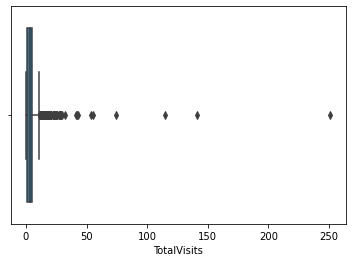

In [169]:
sns.boxplot(df["TotalVisits"])
plt.show()

In [170]:
df["TotalVisits"].quantile([0.25,0.5,0.75,0.9,0.95,0.99,1])

0.25      1.0
0.50      3.0
0.75      5.0
0.90      7.0
0.95     10.0
0.99     17.0
1.00    251.0
Name: TotalVisits, dtype: float64

We have observed that TotalVisits do have a few outliers, and therefore have capped them at 0.95 percentile. Which means, the highest TotalVisits is 10 (0.95 percentile), anything above, will now be replaced with 10.

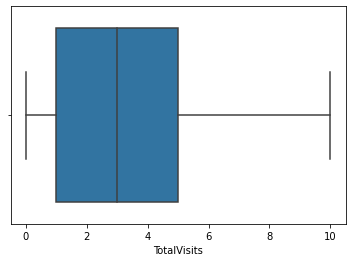

In [171]:
percentiles = df["TotalVisits"].quantile([0,0.95]).values
df["TotalVisits"][df["TotalVisits"] <= percentiles[0]] = percentiles[0]
df["TotalVisits"][df["TotalVisits"] >= percentiles[1]] = percentiles[1]
sns.boxplot(df["TotalVisits"])
plt.show()

<AxesSubplot:xlabel='Page Views Per Visit'>

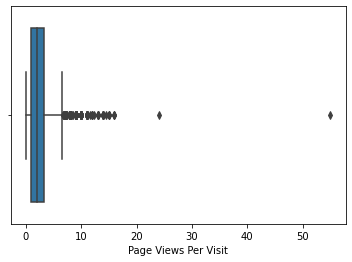

In [172]:
sns.boxplot(df["Page Views Per Visit"])

In [173]:
df["Page Views Per Visit"].quantile([0,0.25,0.5,0.75,0.9,0.95,0.99,1])

0.00     0.0
0.25     1.0
0.50     2.0
0.75     3.2
0.90     5.0
0.95     6.0
0.99     9.0
1.00    55.0
Name: Page Views Per Visit, dtype: float64

We have also observed that Page Views Per Visit has outliers as well. Therefore have capped the outliers at 0.95 percentile as well. Thereby, 6 will now be the highest Page Views per Visit

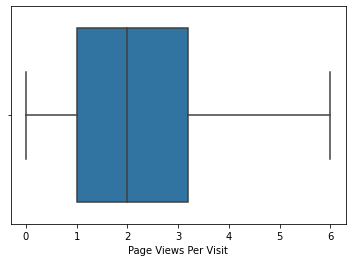

In [174]:
percentiles = df["Page Views Per Visit"].quantile([0,0.95]).values
df["Page Views Per Visit"][df["Page Views Per Visit"] <= percentiles[0]] = percentiles[0]
df["Page Views Per Visit"][df["Page Views Per Visit"] >= percentiles[1]] = percentiles[1]
sns.boxplot(df["Page Views Per Visit"])
plt.show()

We have capped the outliers at the 95 percentile.

<AxesSubplot:xlabel='Total Time Spent on Website'>

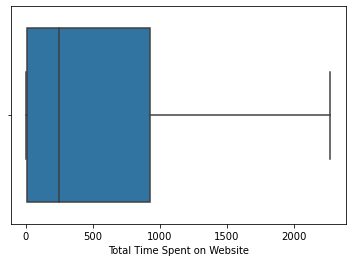

In [175]:
sns.boxplot(df["Total Time Spent on Website"])

No outliers observed.

In [176]:
df.columns

Index(['Lead Number', 'Lead Origin', 'Lead Source', 'Receive Emails?',
       'Receive Calls?', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity',
       'Specialization', 'What is your current occupation', 'Tags',
       'Lead Quality', 'City', 'A free copy of Mastering The Interview',
       'Last Notable Activity'],
      dtype='object')

### Get dummy variables for categorical variables:

In [177]:
df["A free copy of Mastering The Interview"].replace(("Yes","No"),(1,0), inplace=True)

In [178]:
num_var = ["TotalVisits", "Total Time Spent on Website","Page Views Per Visit"]
cat_var = ["Lead Origin", "Lead Source","Last Activity","Specialization","What is your current occupation", "Tags",
          "Lead Quality", "City","Last Notable Activity"]

In [179]:
dummy = pd.get_dummies(df[cat_var], drop_first=True)
dummy.head()

,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Others,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Olark Chat Conversation,Last Activity_Others,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Specialization_Unknown,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Tags_Busy,Tags_Closed by Horizzon,Tags_Diploma holder (Not Eligible),Tags_Graduation in progress,Tags_Interested in full time MBA,Tags_Interested in other courses,Tags_Lost to EINS,Tags_Not doing further education,Tags_Others,Tags_Ringing,Tags_Unknown,Tags_Will revert after reading the email,Tags_invalid number,Tags_switched off,Tags_wrong number given,Lead Quality_Low in Relevance,Lead Quality_Might be,Lead Quality_Not Sure,Lead Quality_Unknown,Lead Quality_Worst,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities,City_Unknown,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Others,Last Notable Activity_Page Visited on Website,Last Notable Activity_SMS Sent
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [180]:
df = pd.concat([df, dummy], axis=1)
df.shape

(9074, 92)

In [181]:
# Drop the original columns:
df.drop(["Lead Origin", "Lead Source","Last Activity","Specialization","What is your current occupation", "Tags",
          "Lead Quality", "City","Last Notable Activity"], axis=1, inplace=True)
df.head()

,Lead Number,Receive Emails?,Receive Calls?,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Others,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Olark Chat Conversation,Last Activity_Others,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Specialization_Unknown,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Tags_Busy,Tags_Closed by Horizzon,Tags_Diploma holder (Not Eligible),Tags_Graduation in progress,Tags_Interested in full time MBA,Tags_Interested in other courses,Tags_Lost to EINS,Tags_Not doing further education,Tags_Others,Tags_Ringing,Tags_Unknown,Tags_Will revert after reading the email,Tags_invalid number,Tags_switched off,Tags_wrong number given,Lead Quality_Low in Relevance,Lead Quality_Might be,Lead Quality_Not Sure,Lead Quality_Unknown,Lead Quality_Worst,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities,City_Unknown,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Others,Last Notable Activity_Page Visited on Website,Last Notable Activity_SMS Sent
0,660737,1,1,0,0.0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,660728,1,1,0,5.0,674,2.5,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0
2,660727,1,1,1,2.0,1532,2.0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,660719,1,1,0,1.0,305,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,660681,1,1,1,2.0,1428,1.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [182]:
df.shape

(9074, 83)

## Model Building

### Test-train split:

In [183]:
X = df.drop(["Lead Number", "Converted"], axis=1)
y = df["Converted"]

In [184]:
# Split the data into train and test:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=100)

### Feature Scaling:

In [185]:
scaler = StandardScaler()
X_train[num_var] = scaler.fit_transform(X_train[num_var])
X_train.head()

,Receive Emails?,Receive Calls?,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Others,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Last Activity_Email Bounced,Last Activity_Email Link Clicked,Last Activity_Email Opened,Last Activity_Form Submitted on Website,Last Activity_Olark Chat Conversation,Last Activity_Others,Last Activity_Page Visited on Website,Last Activity_SMS Sent,Last Activity_Unreachable,Last Activity_Unsubscribed,Specialization_Business Administration,Specialization_E-Business,Specialization_E-COMMERCE,Specialization_Finance Management,Specialization_Healthcare Management,Specialization_Hospitality Management,Specialization_Human Resource Management,Specialization_IT Projects Management,Specialization_International Business,Specialization_Marketing Management,Specialization_Media and Advertising,Specialization_Operations Management,Specialization_Retail Management,Specialization_Rural and Agribusiness,Specialization_Services Excellence,Specialization_Supply Chain Management,Specialization_Travel and Tourism,Specialization_Unknown,What is your current occupation_Housewife,What is your current occupation_Other,What is your current occupation_Student,What is your current occupation_Unemployed,What is your current occupation_Working Professional,Tags_Busy,Tags_Closed by Horizzon,Tags_Diploma holder (Not Eligible),Tags_Graduation in progress,Tags_Interested in full time MBA,Tags_Interested in other courses,Tags_Lost to EINS,Tags_Not doing further education,Tags_Others,Tags_Ringing,Tags_Unknown,Tags_Will revert after reading the email,Tags_invalid number,Tags_switched off,Tags_wrong number given,Lead Quality_Low in Relevance,Lead Quality_Might be,Lead Quality_Not Sure,Lead Quality_Unknown,Lead Quality_Worst,City_Other Cities,City_Other Cities of Maharashtra,City_Other Metro Cities,City_Thane & Outskirts,City_Tier II Cities,City_Unknown,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Others,Last Notable Activity_Page Visited on Website,Last Notable Activity_SMS Sent
3009,1,1,-0.432779,-0.160255,-0.155018,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
1012,0,1,-0.432779,-0.540048,-0.155018,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
9226,1,1,-1.150329,-0.888650,-1.265540,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0
4750,1,1,-0.432779,1.643304,-0.155018,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
7987,1,1,0.643547,2.017593,0.122613,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0


### Correlations:

In [186]:
X.corr().unstack().sort_values(ascending=False).drop_duplicates().head(10)

Receive Emails?                                Receive Emails?                           1.000000
Lead Origin_Lead Add Form                      Lead Source_Reference                     0.866191
Last Activity_Email Opened                     Last Notable Activity_Email Opened        0.861636
Last Activity_SMS Sent                         Last Notable Activity_SMS Sent            0.853102
City_Unknown                                   Specialization_Unknown                    0.852860
TotalVisits                                    Page Views Per Visit                      0.766567
Lead Origin_Lead Import                        Lead Source_Others                        0.744366
Tags_Unknown                                   Lead Quality_Unknown                      0.718408
Last Notable Activity_Page Visited on Website  Last Activity_Page Visited on Website     0.691811
Lead Origin_Landing Page Submission            A free copy of Mastering The Interview    0.564863
dtype: float64

In [187]:
X.corr().unstack().sort_values(ascending=True).drop_duplicates().head(10)

What is your current occupation_Working Professional  What is your current occupation_Unemployed   -0.847891
Lead Origin_Landing Page Submission                   City_Unknown                                 -0.818230
Specialization_Unknown                                Lead Origin_Landing Page Submission          -0.755381
Receive Emails?                                       Last Activity_Email Bounced                  -0.620041
Page Views Per Visit                                  Lead Source_Olark Chat                       -0.579202
City_Unknown                                          A free copy of Mastering The Interview       -0.548985
Lead Quality_Unknown                                  Tags_Will revert after reading the email     -0.536823
Lead Origin_Landing Page Submission                   Lead Source_Olark Chat                       -0.528424
Specialization_Unknown                                A free copy of Mastering The Interview       -0.511384
Last Activity_SMS S

In [188]:
## Drop highly correlated dummy valiables:
X_test.drop(["Last Activity_Email Opened","Last Activity_SMS Sent","Lead Source_Reference",
            "What is your current occupation_Unemployed"], axis=1, inplace=True)
X_train.drop(["Last Activity_Email Opened","Last Activity_SMS Sent","Lead Source_Reference",
             "What is your current occupation_Unemployed"], axis=1, inplace=True)


### Training the model

In [189]:
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6273
Model Family:                Binomial   Df Model:                           77
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1096.1
Date:                Tue, 10 May 2022   Deviance:                       2192.2
Time:                        20:32:27   Pearson chi2:                 1.58e+04
No. Iterations:                    24                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   17.2139   1.34e+05      0.000      1.000   -2.62e+05    2.62e+05
Receive Emails?                                          1.1032      0.350      3.151      0.002       0.417       1.790
Receive Calls?                                         -21.8170   1.34e+05     -0.000      1.000   -2.62e+05    2.62e+05
TotalVisits                                              0.3663      0.095      3.872      0.000       0.181       0.552
Total Time Spent on Website                              1.1766      0.068     17.219      0.000       1.043       1.311
Page Views Per Visit                                    -0.3900      0.108     -3.599      0.000      -0.602      -0.178
A free copy of Mastering The Interview                  -0.2080      0.195     -1.069      0.285      -0.589       0.173
Lead Origin_Landing Page Submission                     -0.7921      0.272     -2.910      0.004      -1.326      -0.259
Lead Origin_Lead Add Form                                1.0395      0.534      1.945      0.052      -0.008       2.087
Lead Origin_Lead Import                                  1.3664      1.268      1.077      0.281      -1.120       3.852
Lead Source_Google                                       0.1603      0.198      0.809      0.418      -0.228       0.549
Lead Source_Olark Chat                                   1.0539      0.263      4.002      0.000       0.538       1.570
Lead Source_Organic Search                              -0.0468      0.232     -0.202      0.840      -0.501       0.408
Lead Source_Others                                       0.1410      0.863      0.163      0.870      -1.550       1.832
Lead Source_Referral Sites                              -0.0925      0.534     -0.173      0.863      -1.139       0.954
Lead Source_Welingak Website                             4.4627      0.884      5.046      0.000       2.729       6.196
Last Activity_Email Bounced                             -0.5550      0.676     -0.821      0.412      -1.880       0.770
Last Activity_Email Link Clicked                         0.2113      0.638      0.331      0.741      -1.039       1.462
Last Activity_Form Submitted on Website                 -0.6997      0.631     -1.108      0.268      -1.937       0.538
Last Activity_Olark Chat Conversation                   -1.1758      0.292     -4.030      0.000      -1.748      -0.604
Last Activity_Others                                     0.8640      1.092      0.791      0.429      -1.276       3.004
Last Activity_Page Visited on Website                   -0.4294      0.417     -1.030      0.303      -1.247       0.388
Last Activity_Unreachable                               -0

### Feature selection using RFE: 

In [190]:
logreg = LogisticRegression()

rfe = RFE(logreg, 15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)

In [191]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('Receive Emails?', True, 1),
 ('Receive Calls?', False, 53),
 ('TotalVisits', False, 27),
 ('Total Time Spent on Website', False, 3),
 ('Page Views Per Visit', False, 26),
 ('A free copy of Mastering The Interview', False, 31),
 ('Lead Origin_Landing Page Submission', False, 5),
 ('Lead Origin_Lead Add Form', True, 1),
 ('Lead Origin_Lead Import', False, 7),
 ('Lead Source_Google', False, 45),
 ('Lead Source_Olark Chat', False, 2),
 ('Lead Source_Organic Search', False, 58),
 ('Lead Source_Others', False, 42),
 ('Lead Source_Referral Sites', False, 52),
 ('Lead Source_Welingak Website', True, 1),
 ('Last Activity_Email Bounced', False, 22),
 ('Last Activity_Email Link Clicked', False, 16),
 ('Last Activity_Form Submitted on Website', False, 20),
 ('Last Activity_Olark Chat Conversation', True, 1),
 ('Last Activity_Others', False, 11),
 ('Last Activity_Page Visited on Website', False, 23),
 ('Last Activity_Unreachable', False, 47),
 ('Last Activity_Unsubscribed', False, 57),
 ('Specia

In [192]:
col = X_train.columns[rfe.support_]
col

Index(['Receive Emails?', 'Lead Origin_Lead Add Form',
       'Lead Source_Welingak Website', 'Last Activity_Olark Chat Conversation',
       'Tags_Busy', 'Tags_Closed by Horizzon', 'Tags_Lost to EINS',
       'Tags_Ringing', 'Tags_Unknown',
       'Tags_Will revert after reading the email', 'Tags_invalid number',
       'Tags_switched off', 'Tags_wrong number given', 'Lead Quality_Worst',
       'Last Notable Activity_SMS Sent'],
      dtype='object')

### Assessing the model with StatsModel:

In [193]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6335
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1370.1
Date:                Tue, 10 May 2022   Deviance:                       2740.1
Time:                        20:32:32   Pearson chi2:                 9.17e+03
No. Iterations:                    23                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -4.5141      0.294    -15.348      0.000      -5.091      -3.938
Receive Emails?                              1.4080      0.234      6.013      0.000       0.949       1.867
Lead Origin_Lead Add Form                    0.6134      0.421      1.456      0.145      -0.212       1.439
Lead Source_Welingak Website                 3.9945      0.848      4.710      0.000       2.332       5.657
Last Activity_Olark Chat Conversation       -1.3101      0.208     -6.296      0.000      -1.718      -0.902
Tags_Busy                                    1.9506      0.293      6.655      0.000       1.376       2.525
Tags_Closed by Horizzon                      7.6825      0.742     10.351      0.000       6.228       9.137
Tags_Lost to EINS                            7.5173      0.758      9.918      0.000       6.032       9.003
Tags_Ringing                                -2.2030      0.306     -7.196      0.000      -2.803      -1.603
Tags_Unknown                                 1.5459      0.194      7.964      0.000       1.165       1.926
Tags_Will revert after reading the email     6.2636      0.255     24.549      0.000       5.764       6.764
Tags_invalid number                        -22.5124   1.47e+04     -0.002      0.999   -2.89e+04    2.88e+04
Tags_switched off                           -2.2188      0.553     -4.009      0.000      -3.303      -1.134
Tags_wrong number given                    -22.4911   2.06e+04     -0.001      0.999   -4.03e+04    4.03e+04
Lead Quality_Worst                          -2.0820      0.728     -2.861      0.004      -3.508      -0.656
Last Notable Activity_SMS Sent               2.6884      0.126     21.366      0.000       2.442       2.935
============================================================================================================
"""

In [194]:
## Drop variables with the highest p values:

col = col.drop("Tags_wrong number given",1)
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6336
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1374.0
Date:                Tue, 10 May 2022   Deviance:                       2748.0
Time:                        20:32:32   Pearson chi2:                 9.15e+03
No. Iterations:                    23                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -4.6242      0.294    -15.754      0.000      -5.200      -4.049
Receive Emails?                              1.4153      0.233      6.066      0.000       0.958       1.873
Lead Origin_Lead Add Form                    0.6349      0.423      1.502      0.133      -0.194       1.463
Lead Source_Welingak Website                 3.9710      0.849      4.678      0.000       2.307       5.635
Last Activity_Olark Chat Conversation       -1.3101      0.208     -6.294      0.000      -1.718      -0.902
Tags_Busy                                    2.0681      0.292      7.087      0.000       1.496       2.640
Tags_Closed by Horizzon                      7.7792      0.742     10.479      0.000       6.324       9.234
Tags_Lost to EINS                            7.6112      0.757     10.050      0.000       6.127       9.096
Tags_Ringing                                -2.0769      0.304     -6.821      0.000      -2.674      -1.480
Tags_Unknown                                 1.6556      0.194      8.524      0.000       1.275       2.036
Tags_Will revert after reading the email     6.3673      0.256     24.898      0.000       5.866       6.869
Tags_invalid number                        -22.3878   1.47e+04     -0.002      0.999   -2.89e+04    2.89e+04
Tags_switched off                           -2.0904      0.552     -3.785      0.000      -3.173      -1.008
Lead Quality_Worst                          -2.0472      0.732     -2.795      0.005      -3.483      -0.612
Last Notable Activity_SMS Sent               2.6603      0.125     21.357      0.000       2.416       2.904
============================================================================================================
"""

In [195]:
## Drop variable with highest p-value:

col = col.drop("Tags_invalid number",1)
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6337
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1380.7
Date:                Tue, 10 May 2022   Deviance:                       2761.3
Time:                        20:32:33   Pearson chi2:                 9.16e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -4.7912      0.294    -16.273      0.000      -5.368      -4.214
Receive Emails?                              1.4104      0.233      6.063      0.000       0.954       1.866
Lead Origin_Lead Add Form                    0.6692      0.425      1.573      0.116      -0.165       1.503
Lead Source_Welingak Website                 3.9298      0.850      4.624      0.000       2.264       5.595
Last Activity_Olark Chat Conversation       -1.3111      0.208     -6.297      0.000      -1.719      -0.903
Tags_Busy                                    2.2634      0.290      7.809      0.000       1.695       2.831
Tags_Closed by Horizzon                      7.9425      0.743     10.693      0.000       6.487       9.398
Tags_Lost to EINS                            7.7834      0.758     10.266      0.000       6.297       9.269
Tags_Ringing                                -1.8674      0.302     -6.184      0.000      -2.459      -1.276
Tags_Unknown                                 1.8381      0.195      9.444      0.000       1.457       2.220
Tags_Will revert after reading the email     6.5395      0.257     25.458      0.000       6.036       7.043
Tags_switched off                           -1.8778      0.551     -3.410      0.001      -2.957      -0.798
Lead Quality_Worst                          -2.0532      0.733     -2.800      0.005      -3.491      -0.616
Last Notable Activity_SMS Sent               2.6138      0.123     21.298      0.000       2.373       2.854
============================================================================================================
"""

In [196]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.17613786, 0.04958975, 0.00522941, 0.74480473, 0.98790279,
       0.99689753, 0.17613786, 0.81703874, 0.95924703, 0.00522941])

In [197]:
# Create a dataframe with the probability of each lead being converted: 
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Converted_prob':y_train_pred})
y_train_pred_final['Lead Number'] = y_train.index

y_train_pred_final.head()

,Converted,Converted_prob,Lead Number
0,0,0.176138,3009
1,0,0.049590,1012
2,0,0.005229,9226
3,1,0.744805,4750
4,1,0.987903,7987


In [198]:
y_train_pred_final['predicted'] = y_train_pred_final.Converted_prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()


,Converted,Converted_prob,Lead Number,predicted
0,0,0.176138,3009,0
1,0,0.049590,1012,0
2,0,0.005229,9226,0
3,1,0.744805,4750,1
4,1,0.987903,7987,1


### Confusion matrix:


In [199]:
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted )
print(confusion)

[[3770  135]
 [ 335 2111]]


In [200]:
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

0.9259959061565108


Accuracy indicates how many leads were identified correctly as conversions. Here almost 93% of the data is accurately predicted.

Accuracy = Correctly Predicted Labels / Total Number of Labels 

or Accuracy = TN + TP / TN + TP + FN + FP

### Checking VIFs:

In [201]:
## Using VIF to further eliminate variables: 

vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


,Features,VIF
0,Receive Emails?,5.57
8,Tags_Unknown,2.77
9,Tags_Will revert after reading the email,2.62
7,Tags_Ringing,1.72
1,Lead Origin_Lead Add Form,1.61
12,Last Notable Activity_SMS Sent,1.61
2,Lead Source_Welingak Website,1.37
5,Tags_Closed by Horizzon,1.32
11,Lead Quality_Worst,1.24
3,Last Activity_Olark Chat Conversation,1.22


In [202]:
# Drop column with highest VIF:
col = col.drop("Receive Emails?",1)
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6338
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1403.4
Date:                Tue, 10 May 2022   Deviance:                       2806.9
Time:                        20:32:33   Pearson chi2:                 8.67e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -3.4903      0.191    -18.310      0.000      -3.864      -3.117
Lead Origin_Lead Add Form                    0.6363      0.429      1.485      0.138      -0.204       1.476
Lead Source_Welingak Website                 3.8376      0.845      4.544      0.000       2.182       5.493
Last Activity_Olark Chat Conversation       -1.2310      0.208     -5.917      0.000      -1.639      -0.823
Tags_Busy                                    2.3233      0.291      7.987      0.000       1.753       2.893
Tags_Closed by Horizzon                      8.0354      0.743     10.810      0.000       6.579       9.492
Tags_Lost to EINS                            7.8630      0.761     10.330      0.000       6.371       9.355
Tags_Ringing                                -1.8485      0.301     -6.136      0.000      -2.439      -1.258
Tags_Unknown                                 1.8360      0.194      9.441      0.000       1.455       2.217
Tags_Will revert after reading the email     6.5715      0.257     25.613      0.000       6.069       7.074
Tags_switched off                           -1.9507      0.549     -3.552      0.000      -3.027      -0.874
Lead Quality_Worst                          -2.1183      0.720     -2.941      0.003      -3.530      -0.706
Last Notable Activity_SMS Sent               2.6234      0.121     21.631      0.000       2.386       2.861
============================================================================================================
"""

In [203]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Converted_prob':y_train_pred})
y_train_pred_final['Lead Number'] = y_train.index
y_train_pred_final = y_train_pred_final.reset_index()
y_train_pred_final.head()

y_train_pred_final['predicted'] = y_train_pred_final.Converted_prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()


,index,Converted,Converted_prob,Lead Number,predicted
0,3009,0,0.160529,3009,0
1,1012,0,0.160529,1012,0
2,9226,0,0.004779,9226,0
3,4750,1,0.724943,4750,1
4,7987,1,0.987539,7987,1


In [204]:
# Check if accuracy has dropped significantly:
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

0.9256809951188789


In [205]:
# Check VIFs again:
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


,Features,VIF
1,Lead Source_Welingak Website,1.37
4,Tags_Closed by Horizzon,1.12
3,Tags_Busy,1.04
9,Tags_switched off,1.03
5,Tags_Lost to EINS,1.00
0,Lead Origin_Lead Add Form,0.67
10,Lead Quality_Worst,0.37
2,Last Activity_Olark Chat Conversation,0.27
8,Tags_Will revert after reading the email,0.16
6,Tags_Ringing,0.07


In [206]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6338
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1403.4
Date:                Tue, 10 May 2022   Deviance:                       2806.9
Time:                        20:32:33   Pearson chi2:                 8.67e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -3.4903      0.191    -18.310      0.000      -3.864      -3.117
Lead Origin_Lead Add Form                    0.6363      0.429      1.485      0.138      -0.204       1.476
Lead Source_Welingak Website                 3.8376      0.845      4.544      0.000       2.182       5.493
Last Activity_Olark Chat Conversation       -1.2310      0.208     -5.917      0.000      -1.639      -0.823
Tags_Busy                                    2.3233      0.291      7.987      0.000       1.753       2.893
Tags_Closed by Horizzon                      8.0354      0.743     10.810      0.000       6.579       9.492
Tags_Lost to EINS                            7.8630      0.761     10.330      0.000       6.371       9.355
Tags_Ringing                                -1.8485      0.301     -6.136      0.000      -2.439      -1.258
Tags_Unknown                                 1.8360      0.194      9.441      0.000       1.455       2.217
Tags_Will revert after reading the email     6.5715      0.257     25.613      0.000       6.069       7.074
Tags_switched off                           -1.9507      0.549     -3.552      0.000      -3.027      -0.874
Lead Quality_Worst                          -2.1183      0.720     -2.941      0.003      -3.530      -0.706
Last Notable Activity_SMS Sent               2.6234      0.121     21.631      0.000       2.386       2.861
============================================================================================================
"""

In [207]:
# Drop variable with high p-value:

col = col.drop("Lead Origin_Lead Add Form",1)

In [208]:
# Check VIFs again:
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif


,Features,VIF
0,Lead Source_Welingak Website,1.05
2,Tags_Busy,1.04
8,Tags_switched off,1.03
3,Tags_Closed by Horizzon,1.01
4,Tags_Lost to EINS,1.00
9,Lead Quality_Worst,0.37
1,Last Activity_Olark Chat Conversation,0.27
7,Tags_Will revert after reading the email,0.15
5,Tags_Ringing,0.07
10,Last Notable Activity_SMS Sent,0.02


In [209]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6339
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1404.6
Date:                Tue, 10 May 2022   Deviance:                       2809.2
Time:                        20:32:33   Pearson chi2:                 8.64e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -3.4772      0.190    -18.299      0.000      -3.850      -3.105
Lead Source_Welingak Website                 4.4716      0.729      6.137      0.000       3.043       5.900
Last Activity_Olark Chat Conversation       -1.2403      0.209     -5.937      0.000      -1.650      -0.831
Tags_Busy                                    2.3073      0.291      7.940      0.000       1.738       2.877
Tags_Closed by Horizzon                      8.2333      0.736     11.189      0.000       6.791       9.676
Tags_Lost to EINS                            7.8797      0.760     10.373      0.000       6.391       9.369
Tags_Ringing                                -1.8339      0.300     -6.103      0.000      -2.423      -1.245
Tags_Unknown                                 1.8244      0.194      9.406      0.000       1.444       2.205
Tags_Will revert after reading the email     6.6160      0.256     25.893      0.000       6.115       7.117
Tags_switched off                           -1.9689      0.549     -3.586      0.000      -3.045      -0.893
Lead Quality_Worst                          -2.1255      0.716     -2.969      0.003      -3.528      -0.723
Last Notable Activity_SMS Sent               2.6290      0.121     21.696      0.000       2.392       2.867
============================================================================================================
"""

In [210]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Converted_prob':y_train_pred})
y_train_pred_final['Lead Number'] = y_train.index
y_train_pred_final = y_train_pred_final.reset_index()
y_train_pred_final.head()

y_train_pred_final['predicted'] = y_train_pred_final.Converted_prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()


,index,Converted,Converted_prob,Lead Number,predicted
0,3009,0,0.160736,3009,0
1,1012,0,0.160736,1012,0
2,9226,0,0.004913,9226,0
3,4750,1,0.726363,4750,1
4,7987,1,0.987902,7987,1


In [211]:
# Check if accuracy has dropped significantly:
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

0.9256809951188789


In [212]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [213]:
## Check all other metrices:

# Sensitivity - Correctly predicted coverted leads (higher the better):
TP / float(TP+FN)

0.8630417007358954

In [214]:
# Specificity - Correctly predicted non converted leads (higher the better):
TN / float(TN+FP)

0.9654289372599232

In [215]:
# False postive rate - Incorrectly predicted converted leads (lower the better):
print(FP/ float(TN+FP))

0.034571062740076826


In [216]:
# positive predictive value - Rate of correct positive preictions over total positive predictions (Higher the better): 
print (TP / float(TP+FP))

0.939893143365984


In [217]:
# Negative predictive value - Rate of correct negative preictions over total negative predictions (Higher the better):
print (TN / float(TN+ FN))

0.9183922046285018


### Plotting the ROC:

An ROC curve shows the trade off between sensitivity and specificity. Greater the area under the curver (i.e. the greater it curves towards the top left corner), the better the performance.

In [218]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [219]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Converted, 
                                         y_train_pred_final.Converted_prob, drop_intermediate = False )

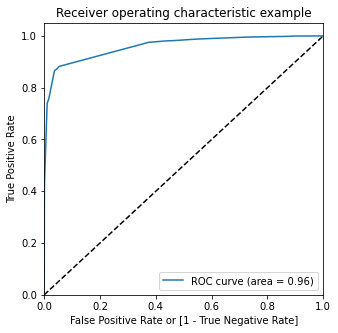

In [220]:
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Converted_prob)

AUC (Area under the curve) or 0.96 is considered to be good.

### Finding Optimal Cutoff Point

Optimal cutoff probability is that prob where we get balanced sensitivity and specificity

In [221]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Converted_prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,index,Converted,Converted_prob,Lead Number,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,3009,0,0.160736,3009,0,1,1,0,0,0,0,0,0,0,0
1,1012,0,0.160736,1012,0,1,1,0,0,0,0,0,0,0,0
2,9226,0,0.004913,9226,0,1,0,0,0,0,0,0,0,0,0
3,4750,1,0.726363,4750,1,1,1,1,1,1,1,1,1,0,0
4,7987,1,0.987902,7987,1,1,1,1,1,1,1,1,1,1,1


In [222]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.385136  1.000000  0.000000
0.1   0.1  0.760038  0.975470  0.625096
0.2   0.2  0.921745  0.882257  0.946479
0.3   0.3  0.925681  0.865904  0.963124
0.4   0.4  0.925681  0.865904  0.963124
0.5   0.5  0.925681  0.865904  0.963124
0.6   0.6  0.925681  0.865904  0.963124
0.7   0.7  0.925681  0.865904  0.963124
0.8   0.8  0.896237  0.756746  0.983611
0.9   0.9  0.889151  0.728536  0.989757


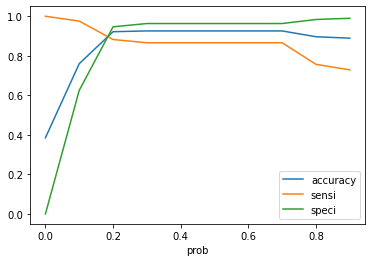

In [223]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

We have decided to pick 0.2 is the optimal probabilty since all 3 factors seem to be balanced around 0.2 probabilty. Which means, anything above a 0.2 probability, will be considered as a hot lead (high chances of being coverted to a customer), and anything below, will be a cold lead.

In [224]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Converted_prob.map( lambda x: 1 if x > 0.22 else 0)

y_train_pred_final.head()

,index,Converted,Converted_prob,Lead Number,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,3009,0,0.160736,3009,0,1,1,0,0,0,0,0,0,0,0,0
1,1012,0,0.160736,1012,0,1,1,0,0,0,0,0,0,0,0,0
2,9226,0,0.004913,9226,0,1,0,0,0,0,0,0,0,0,0,0
3,4750,1,0.726363,4750,1,1,1,1,1,1,1,1,1,0,0,1
4,7987,1,0.987902,7987,1,1,1,1,1,1,1,1,1,1,1,1


In [225]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.9217446071484805

In [226]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion2

array([[3696,  209],
       [ 288, 2158]])

In [227]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8630417007358954

In [228]:
# Let us calculate specificity
TN / float(TN+FP)

0.9654289372599232

In [229]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.034571062740076826


In [230]:
# Positive predictive value 
print (TP / float(TP+FP))

0.939893143365984


In [231]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9183922046285018


##### Precision
TP / TP + FP

In [232]:
confusion[1,1]/(confusion[0,1]+confusion[1,1])

0.939893143365984

##### Recall
TP / TP + FN

In [233]:
confusion[1,1]/(confusion[1,0]+confusion[1,1])

0.8630417007358954

### Precision and recall trade off:

In [234]:
y_train_pred_final.Converted, y_train_pred_final.predicted

(0       0
 1       0
 2       0
 3       1
 4       1
        ..
 6346    0
 6347    1
 6348    0
 6349    0
 6350    0
 Name: Converted, Length: 6351, dtype: int64,
 0       0
 1       0
 2       0
 3       1
 4       1
        ..
 6346    0
 6347    1
 6348    0
 6349    0
 6350    0
 Name: predicted, Length: 6351, dtype: int64)

In [235]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Converted_prob)

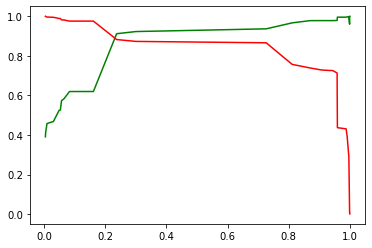

In [236]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

As per the Sensitivity-Specificity-Accuracy plot, 0.2 was the optimal probability. Whereas as per the PR plot, around 0.22 seems to be optimal. We are going with 0.2 to be optimal.

### Making predictions on the test set

In [237]:
X_test[num_var] = scaler.transform(X_test[num_var])

X_test = X_test[col]
X_test.head()

,Lead Source_Welingak Website,Last Activity_Olark Chat Conversation,Tags_Busy,Tags_Closed by Horizzon,Tags_Lost to EINS,Tags_Ringing,Tags_Unknown,Tags_Will revert after reading the email,Tags_switched off,Lead Quality_Worst,Last Notable Activity_SMS Sent
3271,0,0,0,0,0,0,1,0,0,0,0
1490,0,0,0,0,0,0,0,1,0,0,0
7936,0,0,0,0,0,0,1,0,0,0,0
4216,0,0,0,1,0,0,0,0,0,0,0
3830,0,0,0,0,0,0,1,0,0,0,0


In [238]:
X_test = X_test[col]
X_test.head()

,Lead Source_Welingak Website,Last Activity_Olark Chat Conversation,Tags_Busy,Tags_Closed by Horizzon,Tags_Lost to EINS,Tags_Ringing,Tags_Unknown,Tags_Will revert after reading the email,Tags_switched off,Lead Quality_Worst,Last Notable Activity_SMS Sent
3271,0,0,0,0,0,0,1,0,0,0,0
1490,0,0,0,0,0,0,0,1,0,0,0
7936,0,0,0,0,0,0,1,0,0,0,0
4216,0,0,0,1,0,0,0,0,0,0,0
3830,0,0,0,0,0,0,1,0,0,0,0


In [239]:
X_test_sm = sm.add_constant(X_test)

In [240]:
y_test_pred = res.predict(X_test_sm)

In [241]:
y_test_pred[:10]

3271    0.160736
1490    0.958467
7936    0.160736
4216    0.991475
3830    0.160736
1800    0.958467
6507    0.064042
4821    0.004295
4223    0.996883
4714    0.160736
dtype: float64

In [242]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)

In [243]:
# Let's see the head
y_pred_1.head()

,0
3271,0.160736
1490,0.958467
7936,0.160736
4216,0.991475
3830,0.160736


In [244]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [245]:
# Putting Lead Number to index
y_test_df['Lead Number'] = y_test_df.index

In [246]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [247]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [248]:
y_pred_final.head()

,Converted,Lead Number,0
0,0,3271,0.160736
1,1,1490,0.958467
2,0,7936,0.160736
3,1,4216,0.991475
4,0,3830,0.160736


In [249]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : "Converted_Prob"})

In [250]:
# Let's see the head of y_pred_final
y_pred_final.head()

,Converted,Lead Number,Converted_Prob
0,0,3271,0.160736
1,1,1490,0.958467
2,0,7936,0.160736
3,1,4216,0.991475
4,0,3830,0.160736


In [251]:
## Based on the optimal probability obtained above: 

y_pred_final['final_predicted'] = y_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.2 else 0)

In [252]:
y_pred_final.head()

,Converted,Lead Number,Converted_Prob,final_predicted
0,0,3271,0.160736,0
1,1,1490,0.958467,1
2,0,7936,0.160736,0
3,1,4216,0.991475,1
4,0,3830,0.160736,0


In [253]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.Converted, y_pred_final.final_predicted)

0.9184722732280572

In [254]:
confusion2 = metrics.confusion_matrix(y_pred_final.Converted, y_pred_final.final_predicted )
confusion2

array([[1634,  100],
       [ 122,  867]])

In [255]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [256]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8766430738119313

In [257]:
# Let us calculate specificity
TN / float(TN+FP)

0.9423298731257209

In [258]:
y_pred_final.head()

,Converted,Lead Number,Converted_Prob,final_predicted
0,0,3271,0.160736,0
1,1,1490,0.958467,1
2,0,7936,0.160736,0
3,1,4216,0.991475,1
4,0,3830,0.160736,0


In [259]:
y_pred_final["Lead Score"] = y_pred_final.Converted_Prob.map(lambda x: round(x*100))

In [260]:
y_pred_final.head(10)

,Converted,Lead Number,Converted_Prob,final_predicted,Lead Score
0,0,3271,0.160736,0,16
1,1,1490,0.958467,1,96
2,0,7936,0.160736,0,16
3,1,4216,0.991475,1,99
4,0,3830,0.160736,0,16
5,1,1800,0.958467,1,96
6,0,6507,0.064042,0,6
7,0,4821,0.004295,0,0
8,1,4223,0.996883,1,100
9,0,4714,0.160736,0,16


In [261]:
## Final variables used:
print(res.params.sort_values(ascending=False))

Tags_Closed by Horizzon                     8.233323
Tags_Lost to EINS                           7.879748
Tags_Will revert after reading the email    6.616031
Lead Source_Welingak Website                4.471552
Last Notable Activity_SMS Sent              2.629012
Tags_Busy                                   2.307268
Tags_Unknown                                1.824416
Last Activity_Olark Chat Conversation      -1.240321
Tags_Ringing                               -1.833864
Tags_switched off                          -1.968857
Lead Quality_Worst                         -2.125494
const                                      -3.477180
dtype: float64


### Conclusion:

The logistic regression model is used to predict the probability of converting a lead into a customer.

Here the optimal cut off was found to be 0.2, i.e, any lead with a probability of higher than 0.2, is considered to be a hot lead (high chances of turning into a customer), and therefore should be targeted. Whereas any lead with a probability of less than 0.2 is considered to be a cold lead.

Our final model was built using the 12 features (as mentioned above). 
Out of these "Tags_Closed by Horizzon", "Tags_Lost to EINS", "Tags_Will revert after reading the email" are most significant with the highest absolute values of their factors. This indicates that these factors have the highest influence on the model.

The final model has a sensitivity rate of around 88%, i.e. 88% have been correctly identified as hot leads that have been converted. And a specificity rate of 94%, i.e. 94% has been correctly identified as cold leads, that can't be converted.

Therefore the marketing team can now focus on those leads with higher Lead Scores to increase the conversion rate of X Education. 